# Payoff d'options vanille (call / put) sur SPY

Support de TP sur les options européennes vanille : payoff brut, P&L net (prime BS), points morts et widget interactif call/put.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import sys
from pathlib import Path
from IPython.display import display, Markdown

_base = Path.cwd().resolve()
for extra in (_base, _base.parent, _base.parent.parent):
    candidate = extra / "notebooks" / "scripts"
    if candidate.exists() and str(candidate) not in sys.path:
        sys.path.insert(0, str(candidate))
        break
from pricing import fetch_spy_history, view_vanilla_call, view_vanilla_put, payoff_call, payoff_put
plt.style.use("seaborn-v0_8-darkgrid")

close_spy = fetch_spy_history()
spot_ref = float(close_spy.iloc[-1])

strike_ref = spot_ref
view_call = view_vanilla_call(spot_ref, strike_ref)
view_put = view_vanilla_put(spot_ref, strike_ref)


D:\PythonDProjects\PaperTradingApp\notebooks\scripts\pricing.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", period=period, interval=interval, progress=False)
C:\Users\nicol\AppData\Local\Temp\ipykernel_21764\14607432.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spot_ref = float(close_spy.iloc[-1])


## Évolution du sous-jacent (SPY)
Historique des clôtures sur un an et repère du spot de référence (dernier close).


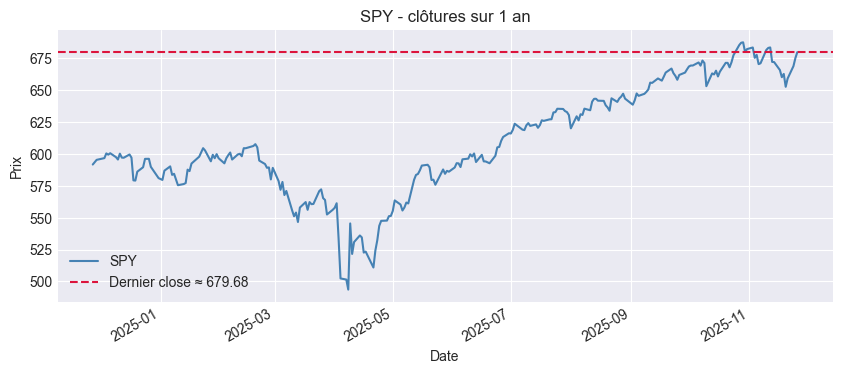

In [2]:

fig, ax = plt.subplots(figsize=(10, 4))
close_spy.plot(ax=ax, color="steelblue", label="SPY close")
ax.axhline(spot_ref, color="crimson", linestyle="--", label=f"Dernier close ≈ {spot_ref:.2f}")
ax.set_title("SPY - clôtures sur 1 an")
ax.set_xlabel("Date")
ax.set_ylabel("Prix")
ax.legend()
plt.show()


## Payoff call / put
Payoff brut et P&L net pour un call et un put européens au même strike. Les points morts sont déduits de la prime BS.


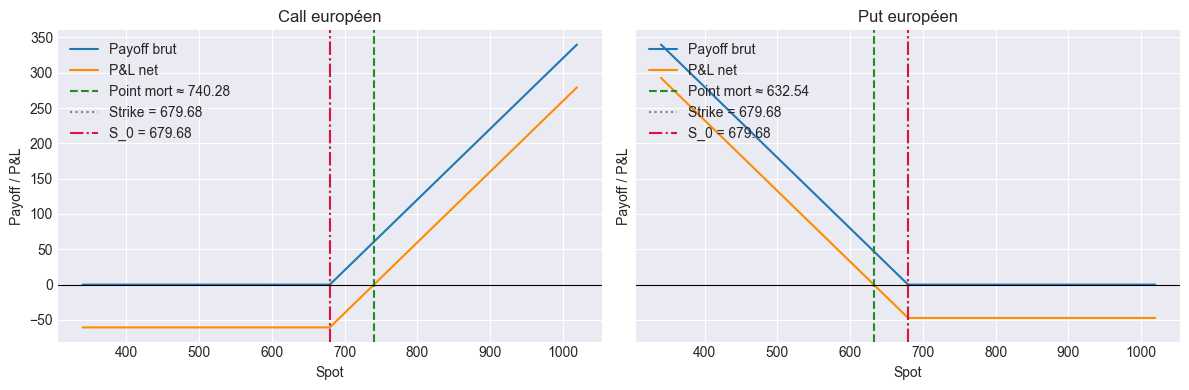

**Prime call (BS) ≈ 60.6005** | **Point mort call ≈ 740.28**

**Prime put (BS) ≈ 47.1420** | **Point mort put ≈ 632.54**

In [3]:

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for ax, (opt, view) in zip(axes, [("Call", view_call), ("Put", view_put)]):
        be = view["breakevens"][0]
        color = "darkorange"
        ax.plot(view["s_grid"], view["payoff"], label="Payoff brut")
        ax.plot(view["s_grid"], view["pnl"], label="P&L net", color=color)
        ax.axvline(be, color="forestgreen", linestyle="--", label=f"Point mort ≈ {be:.2f}")
        ax.axvline(strike_ref, color="gray", linestyle=":" , label=f"Strike = {strike_ref:.2f}")
        ax.axvline(spot_ref, color="crimson", linestyle="-.", label=f"S_0 = {spot_ref:.2f}")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.set_title(f"{opt} européen")
        ax.set_xlabel("Spot")
        ax.set_ylabel("Payoff / P&L")
        ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    display(Markdown(f"""**Prime call (BS) ≈ {view_call['premium']:.4f}** | **Point mort call ≈ {view_call['breakevens'][0]:.2f}**

**Prime put (BS) ≈ {view_put['premium']:.4f}** | **Point mort put ≈ {view_put['breakevens'][0]:.2f}**"""))


## Payoff interactif
Curseurs pour choisir call/put, S_0, S_T et le strike, avec prime et point mort recalculés à la volée.


In [ ]:

option_dd = widgets.Dropdown(options=[('Call', 'call'), ('Put', 'put')], value='call', description='Type')
spot0_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_0')
spotT_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_T')
strike_slider = widgets.FloatSlider(value=strike_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='Strike')
output = widgets.Output()

VIEW_BUILDERS = {'call': view_vanilla_call, 'put': view_vanilla_put}
PAYOFFS = {'call': payoff_call, 'put': payoff_put}

def _update_payoff(change=None):
    with output:
        output.clear_output()
        kind = option_dd.value
        s0 = spot0_slider.value
        sT = spotT_slider.value
        k_val = strike_slider.value

        view_dyn = VIEW_BUILDERS[kind](s0, k_val)
        premium_dyn = view_dyn["premium"]
        be = view_dyn["breakevens"][0]
        payoff_T = float(PAYOFFS[kind](sT, k_val))
        pnl_T = payoff_T - premium_dyn

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(view_dyn["s_grid"], view_dyn["payoff"], label='Payoff brut')
        ax.plot(view_dyn["s_grid"], view_dyn["pnl"], label='P&L net', color='darkorange')
        ax.axvline(k_val, color='gray', linestyle=':', label=f'Strike = {k_val:.2f}')
        ax.axvline(be, color='forestgreen', linestyle='--', label=f'Point mort ≈ {be:.2f}')
        ax.axvline(s0, color='crimson', linestyle='-.', label=f'S_0 = {s0:.2f}')
        ax.axhline(0, color='black', linewidth=0.8)
        ax.scatter([sT], [pnl_T], color='gold', zorder=5, label=f'P&L à S_T = {pnl_T:.2f}')
        ax.set_xlabel('Spot')
        ax.set_ylabel('Payoff / P&L')
        ax.legend(loc='lower right')
        ax.set_title(f"Payoff {kind}")
        plt.show()

        display(Markdown(f"""**Type = {kind.upper()}** | **S_0 = {s0:.2f}**, **S_T = {sT:.2f}**

- Strike = {k_val:.2f}
- Prix (BS) = {premium_dyn:.4f}
- Payoff à l'expiration = {payoff_T:.4f}
- P&L net = {pnl_T:.4f}
- Point mort ≈ {be:.2f}"""))

for sl in (option_dd, spot0_slider, spotT_slider, strike_slider):
    sl.observe(_update_payoff, names='value')

_update_payoff()
display(widgets.VBox([option_dd, spot0_slider, spotT_slider, strike_slider, output]))
